# Segment the adult dataset using GOWER similarity and DBScan Clustering

In [1]:
# Data Visualization:
# DB Scan: 
#   https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6
# Clustering categorical and numeric datset:
# https://towardsdatascience.com/clustering-on-numerical-and-categorical-features-6e0ebcf1cbad
# Clustering Categorical Data Visualization
#   https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0
# Explain Clustering Results with Shapley Values:
#   https://towardsdatascience.com/how-to-make-clustering-explainable-1582390476cc 
#   https://medium.com/bricklane-tech/a-new-approach-to-clustering-interpretation-7729cb665ee8
# Understand tSNE:
#   https://www.youtube.com/watch?v=43ySR7_Yb4E
# General Visualization Strategies for high dim data:
#   https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

In [2]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cluster Explainability
import shap

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets or on kaggle datasets

In [3]:
# CUSTID: Identification of Credit Card holder 
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user  
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

In [4]:
# You have to include the full link to the csv file containing your dataset
df = pd.read_csv('../data/bank_customer_dataset.csv')

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Train-Test Split the Data

In [5]:
df.shape

(8950, 18)

In [6]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.4, random_state=123)

In [7]:
X_train.shape

(5370, 18)

In [8]:
X_test.shape

(3580, 18)

In [9]:
X_train.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5587,C15743,2932.136377,1.0,0.0,0.0,0.0,1866.470014,0.0,0.000000,0.0,0.583333,12,0,3500.0,809.813492,849.210431,0.000000,12
8560,C18793,382.378002,1.0,0.0,0.0,0.0,1097.698179,0.0,0.000000,0.0,0.250000,5,0,1500.0,679.788131,185.106686,0.100000,12
5469,C15622,1097.285930,1.0,0.0,0.0,0.0,37.643261,0.0,0.000000,0.0,0.166667,2,0,1200.0,236.375748,259.212980,0.000000,12
6053,C16224,463.071288,1.0,0.0,0.0,0.0,1381.989484,0.0,0.000000,0.0,0.250000,7,0,1000.0,5445.356870,4496.934117,0.400000,12
3611,C13713,93.672733,1.0,674.3,69.5,604.8,0.000000,1.0,0.166667,1.0,0.000000,0,26,5400.0,812.396962,194.901529,0.083333,12


# Exploratory Data Analysis

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5370 entries, 5587 to 3582
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           5370 non-null   object 
 1   BALANCE                           5370 non-null   float64
 2   BALANCE_FREQUENCY                 5370 non-null   float64
 3   PURCHASES                         5370 non-null   float64
 4   ONEOFF_PURCHASES                  5370 non-null   float64
 5   INSTALLMENTS_PURCHASES            5370 non-null   float64
 6   CASH_ADVANCE                      5370 non-null   float64
 7   PURCHASES_FREQUENCY               5370 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        5370 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  5370 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            5370 non-null   float64
 11  CASH_ADVANCE_TRX                  5370 non-null   int64  
 12  PUR

In [11]:
X_train.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          0
PAYMENTS                              0
MINIMUM_PAYMENTS                    188
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

## Impute Missing Values

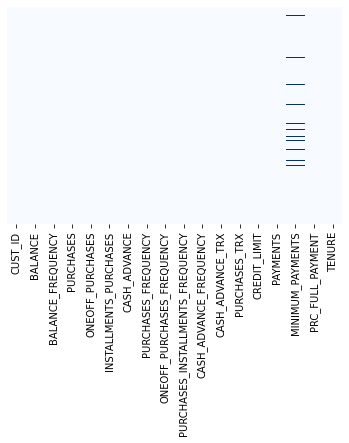

In [12]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [13]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [14]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [15]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['CUST_ID']

In [16]:
# this means except for the customer id there is no categorical feature!

In [17]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5587,2932.136377,1.0,0.0,0.0,0.0,1866.470014,0.0,0.000000,0.0,0.583333,12.0,0.0,3500.0,809.813492,849.210431,0.000000,12.0
8560,382.378002,1.0,0.0,0.0,0.0,1097.698179,0.0,0.000000,0.0,0.250000,5.0,0.0,1500.0,679.788131,185.106686,0.100000,12.0
5469,1097.285930,1.0,0.0,0.0,0.0,37.643261,0.0,0.000000,0.0,0.166667,2.0,0.0,1200.0,236.375748,259.212980,0.000000,12.0
6053,463.071288,1.0,0.0,0.0,0.0,1381.989484,0.0,0.000000,0.0,0.250000,7.0,0.0,1000.0,5445.356870,4496.934117,0.400000,12.0
3611,93.672733,1.0,674.3,69.5,604.8,0.000000,1.0,0.166667,1.0,0.000000,0.0,26.0,5400.0,812.396962,194.901529,0.083333,12.0


In [18]:
## Impute missing categorical values
#categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
#X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
#X_train_categorical.head()

In [19]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

#with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
#    pickle.dump(categorical_imputer, filename)

In [20]:
X_train = X_train_numeric.copy()
X_train.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5587,2932.136377,1.0,0.0,0.0,0.0,1866.470014,0.0,0.000000,0.0,0.583333,12.0,0.0,3500.0,809.813492,849.210431,0.000000,12.0
8560,382.378002,1.0,0.0,0.0,0.0,1097.698179,0.0,0.000000,0.0,0.250000,5.0,0.0,1500.0,679.788131,185.106686,0.100000,12.0
5469,1097.285930,1.0,0.0,0.0,0.0,37.643261,0.0,0.000000,0.0,0.166667,2.0,0.0,1200.0,236.375748,259.212980,0.000000,12.0
6053,463.071288,1.0,0.0,0.0,0.0,1381.989484,0.0,0.000000,0.0,0.250000,7.0,0.0,1000.0,5445.356870,4496.934117,0.400000,12.0
3611,93.672733,1.0,674.3,69.5,604.8,0.000000,1.0,0.166667,1.0,0.000000,0.0,26.0,5400.0,812.396962,194.901529,0.083333,12.0


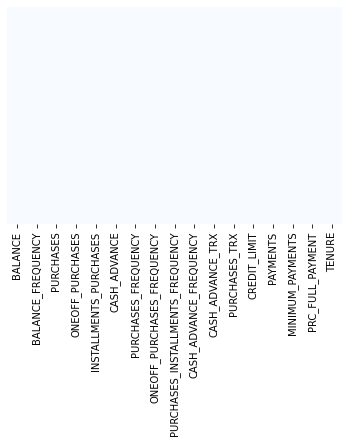

In [21]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Numerical Features

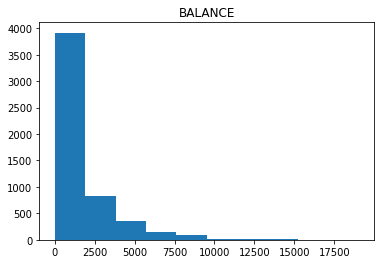

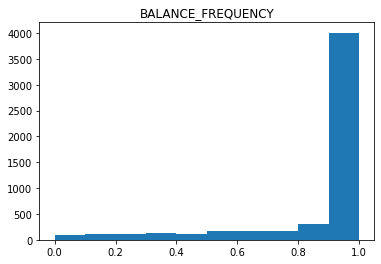

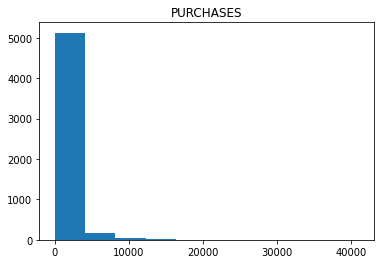

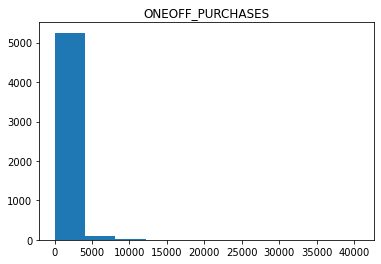

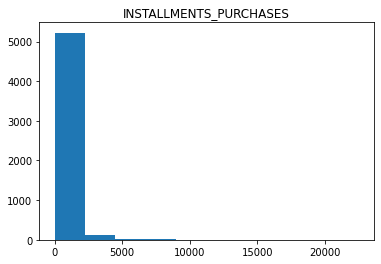

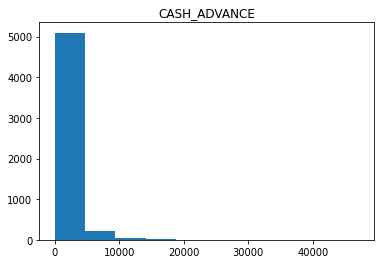

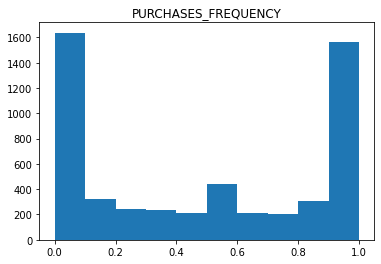

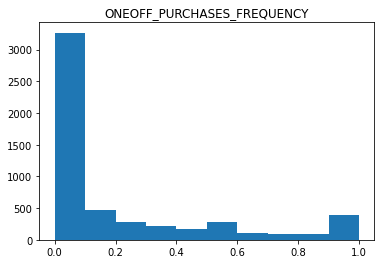

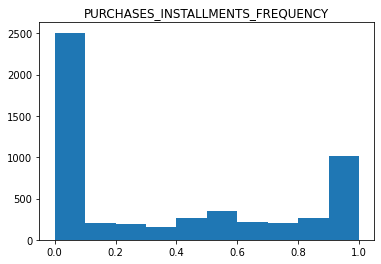

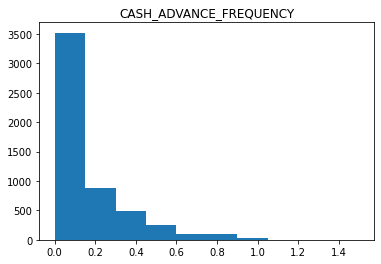

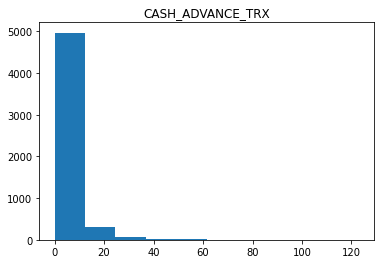

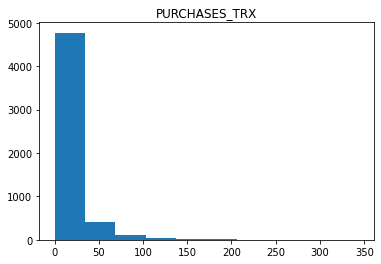

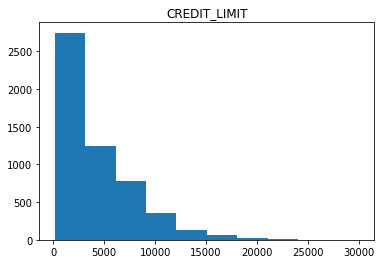

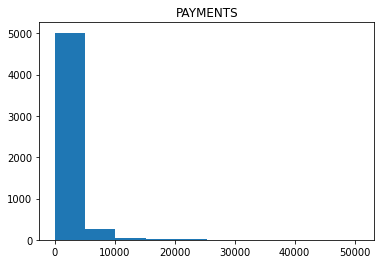

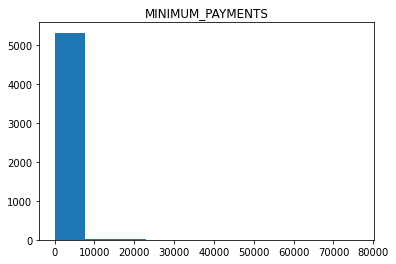

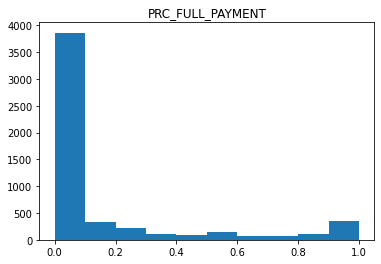

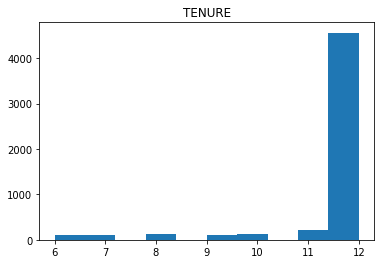

In [22]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [23]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [24]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5587,2932.136377,1.0,0.0,0.0,0.0,1866.470014,0.0,0.000000,0.0,0.583333,12.0,0.0,3500.0,809.813492,849.210431,0.000000,12.0
8560,382.378002,1.0,0.0,0.0,0.0,1097.698179,0.0,0.000000,0.0,0.250000,5.0,0.0,1500.0,679.788131,185.106686,0.100000,12.0
5469,1097.285930,1.0,0.0,0.0,0.0,37.643261,0.0,0.000000,0.0,0.166667,2.0,0.0,1200.0,236.375748,259.212980,0.000000,12.0
6053,463.071288,1.0,0.0,0.0,0.0,1381.989484,0.0,0.000000,0.0,0.250000,7.0,0.0,1000.0,5445.356870,4496.934117,0.400000,12.0
3611,93.672733,1.0,674.3,69.5,604.8,0.000000,1.0,0.166667,1.0,0.000000,0.0,26.0,5400.0,812.396962,194.901529,0.083333,12.0


In [25]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

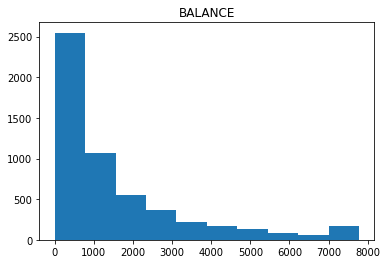

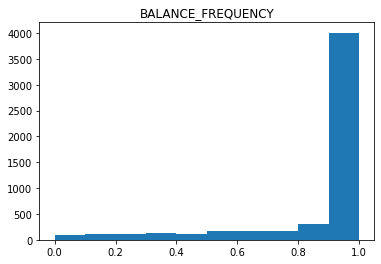

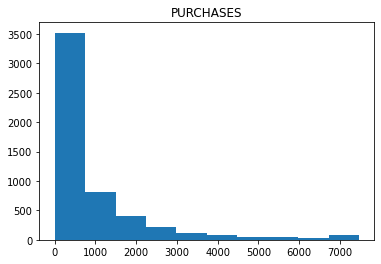

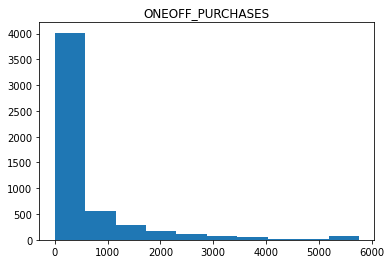

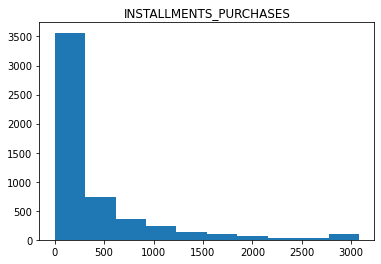

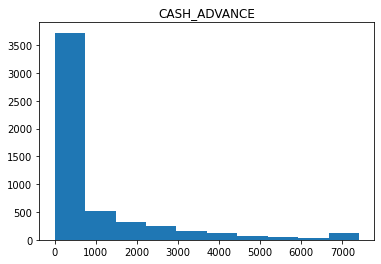

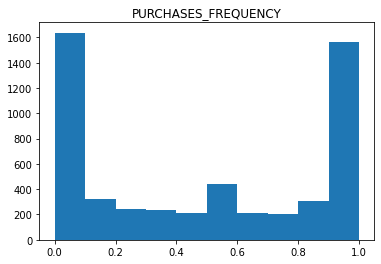

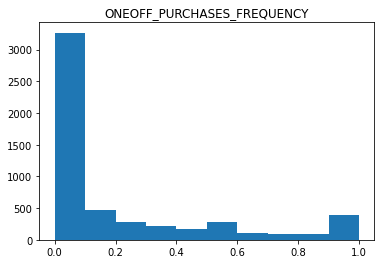

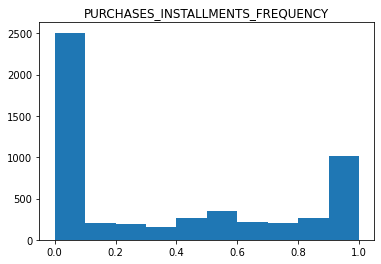

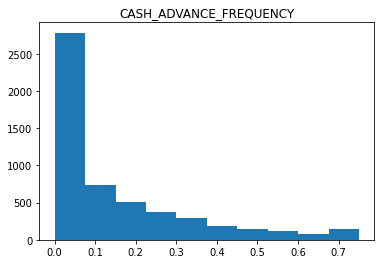

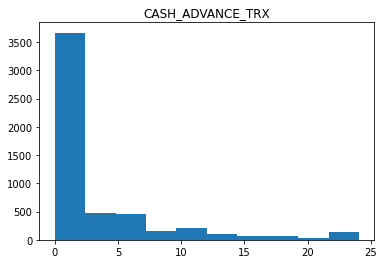

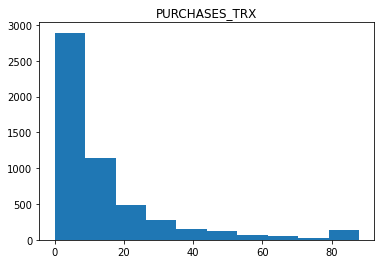

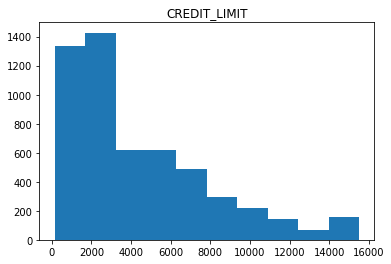

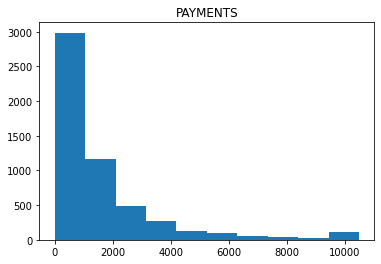

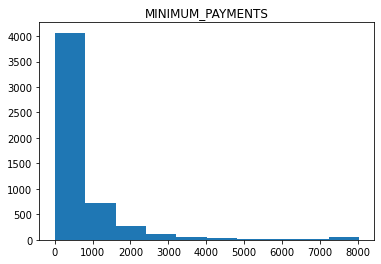

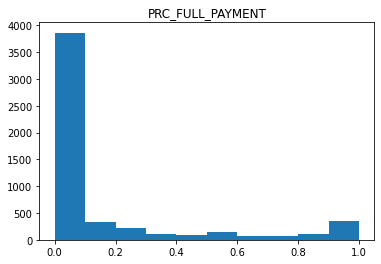

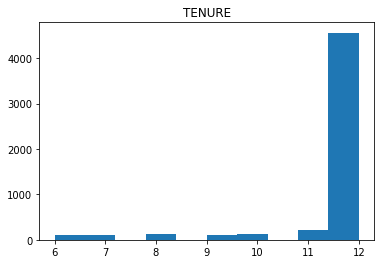

In [26]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Let´s look at Correlated Features

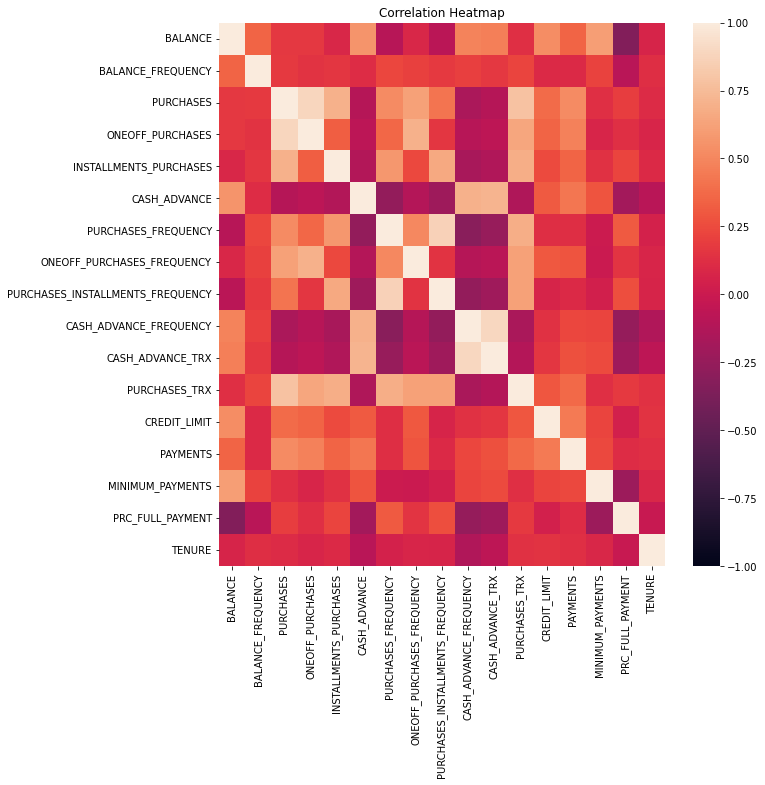

In [27]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,10))
sns.heatmap(
    data=X_train.corr(),
    vmin=-1,
    vmax=1,
    robust=True,
    ax=ax
)
ax.set_title('Correlation Heatmap')
plt.show()

# Feature Compression using PCA

In [28]:
from sklearn.decomposition import PCA

In [29]:
for n in range(10):
    pca = PCA(n_components=n, svd_solver='full')
    pca.fit(X_train)
    print('number components: {} / explained variance: {}'.format(n, pca.explained_variance_ratio_.sum()))

number components: 0 / explained variance: 0.0
number components: 1 / explained variance: 0.5782590938887293
number components: 2 / explained variance: 0.722915497763629
number components: 3 / explained variance: 0.8614383689137582
number components: 4 / explained variance: 0.9336565098427053
number components: 5 / explained variance: 0.9659135170510246
number components: 6 / explained variance: 0.9865042710955283
number components: 7 / explained variance: 0.9994762773946054
number components: 8 / explained variance: 0.9999951508110638
number components: 9 / explained variance: 0.9999994418352671


In [30]:
# lets choose n=4 components
pca = PCA(n_components=10, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)

X_train_pca = pd.DataFrame(
    data=X_train_pca,
    columns=['pc 1', 'pc 2', 'pc 3','pc 4','pc 5','pc 6','pc 7','pc 8','pc 9','pc 10']
)

X_train_pca.head()

,pc 1,pc 2,pc 3,pc 4,pc 5,pc 6,pc 7,pc 8,pc 9,pc 10
0,-681.746974,1737.511994,-1347.200530,-416.388895,-391.670710,-443.374773,23.952477,14.071425,3.311504,5.949153
1,-3419.734239,624.191709,-184.745594,661.038752,-275.889198,79.189356,-100.775215,15.618370,2.667526,1.391581
2,-3784.205490,344.427933,-403.350252,-393.498264,49.748839,-589.279478,-45.335836,19.531539,3.630188,0.305164
3,-1769.245302,3652.467648,2986.188395,475.689750,3676.356770,1834.724991,-1076.655547,-24.302163,2.212866,2.869501
4,-248.017763,-1924.753835,-645.573363,675.898068,328.212238,277.083962,308.328423,-12.354237,-12.334304,-0.368523


In [ ]:
# it turns out that feature compression doesn´t really improve finding clusters; 
# the opposite is the case?!?! why, i haven´t found out yet; maybe b/c the loss of 
# information is too significant b/c PCA only captures linear relationships between features?!
# so let´s continue without PCA!

# Calculate Customer Similarity using Gower´s Distance

In [31]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 1.5 s
Wall time: 1.51 s


In [32]:
distance_matrix.shape

(5370, 5370)

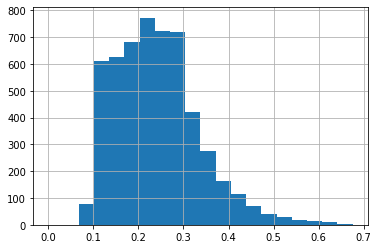

In [33]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [34]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.1 

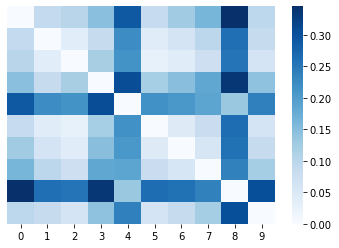

In [35]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [36]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([ 100,  895, 2247, 3688, 4640], dtype=int64),
 'values': array([0.        , 0.04648447, 0.0506317 , 0.05274915, 0.06150863],
       dtype=float32)}

In [37]:
top_n['index']

array([ 100,  895, 2247, 3688, 4640], dtype=int64)

In [38]:
pd.DataFrame(
    data=X_train.iloc[top_n['index'],:],
    columns =X_train.columns
)  

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2431,451.905949,1.0,4468.71,3870.15,598.56,0.0,1.0,1.0,0.416667,0.0,0.0,53.0,4000.0,4009.961094,184.310480,1.000000,12.0
3195,452.094148,1.0,5073.53,4752.26,321.27,0.0,1.0,1.0,0.666667,0.0,0.0,54.0,7000.0,3923.560419,176.275371,1.000000,12.0
4950,468.294595,1.0,4164.14,3215.54,948.60,0.0,1.0,1.0,1.000000,0.0,0.0,53.0,4000.0,3958.926162,203.066713,1.000000,12.0
7655,208.581872,1.0,2608.02,2155.67,452.35,0.0,1.0,1.0,0.416667,0.0,0.0,51.0,3500.0,2625.802250,178.035597,0.916667,12.0
5039,434.099616,1.0,4392.05,3817.98,574.07,0.0,1.0,1.0,1.000000,0.0,0.0,79.0,6000.0,4076.914448,188.019302,1.000000,12.0


# DBScan Clustering

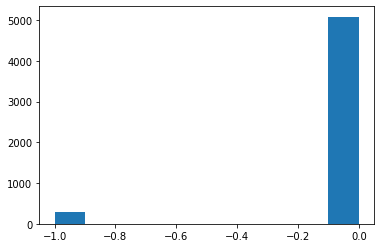

CPU times: total: 344 ms
Wall time: 343 ms


In [39]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [40]:
# Compute Cluster Quality using Silhouette Score
silhouette_score(
    X=distance_matrix, 
    labels=dbscan_cluster.labels_, 
    metric="precomputed")

0.40564752

In [41]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.025, 0.25, .0125)
min_sample_range = np.arange(5, 50, 2)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        
        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))

        if num_cluster_detected >= 2:
            # calculate cluster quality using the silhouette score
            cluster_quality = silhouette_score(X=distance_matrix, 
                                           labels=dbscan_cluster.labels_, 
                                           metric="precomputed")
        else:
            cluster_quality = -1 # the silhouette score is not defined for one single cluster; let´s put the quality then to -1
        
        # save results
        results_list.append([eps, min_samples, cluster_quality, num_cluster_detected, num_noise_data])

In [ ]:
results_list

[[0.025, 5, -0.39814463, 18, 3237],
 [0.025, 7, -0.36828026, 13, 3411],
 [0.025, 9, -0.28851026, 6, 3547],
 [0.025, 11, -0.3369843, 6, 3654],
 [0.025, 13, -0.2865864, 5, 3734],
 [0.025, 15, -0.19429004, 4, 3808],
 [0.025, 17, -0.098965265, 2, 3916],
 [0.025, 19, -0.22031079, 3, 3958],
 [0.025, 21, -0.22139686, 3, 3984],
 [0.025, 23, -0.12409938, 2, 4046],
 [0.025, 25, -0.12898213, 2, 4074],
 [0.025, 27, -0.13379093, 2, 4101],
 [0.025, 29, -0.13728209, 2, 4132],
 [0.025, 31, -0.14330225, 2, 4164],
 [0.025, 33, -0.20770663, 3, 4194],
 [0.025, 35, -0.21063735, 3, 4213],
 [0.025, 37, -0.21792436, 3, 4268],
 [0.025, 39, -0.21883228, 3, 4272],
 [0.025, 41, -0.23307933, 3, 4353],
 [0.025, 43, -0.24701503, 3, 4401],
 [0.025, 45, -0.24852206, 3, 4407],
 [0.025, 47, -0.25076607, 3, 4421],
 [0.025, 49, -0.2538579, 3, 4435],
 [0.037500000000000006, 5, -0.30307585, 9, 2114],
 [0.037500000000000006, 7, -0.17675647, 4, 2263],
 [0.037500000000000006, 9, -0.012851209, 3, 2378],
 [0.037500000000000006, 

In [ ]:
clustering_results_df = pd.DataFrame(results_list, columns = ("eps", "min_samples", "cluster_quality", "num_clusters", "num_noise_data"))
clustering_results_df

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
0,0.0250,5,-0.398145,18,3237
1,0.0250,7,-0.368280,13,3411
2,0.0250,9,-0.288510,6,3547
3,0.0250,11,-0.336984,6,3654
4,0.0250,13,-0.286586,5,3734
...,...,...,...,...,...
409,0.2375,41,-1.000000,1,0
410,0.2375,43,-1.000000,1,0
411,0.2375,45,-1.000000,1,0
412,0.2375,47,-1.000000,1,0


In [ ]:
nclusters = 2
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="cluster_quality", ascending=False)
db_config 

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
121,0.0875,17,0.350751,2,408
47,0.0500,7,0.224580,2,1466
82,0.0625,31,0.134648,2,1311
49,0.0500,11,0.119652,2,1624
26,0.0375,11,0.066971,2,2473
64,0.0500,41,0.021489,2,2199
65,0.0500,43,0.019516,2,2235
30,0.0375,19,-0.009122,2,2716
31,0.0375,21,-0.011137,2,2767
32,0.0375,23,-0.017561,2,2802


0.088 17


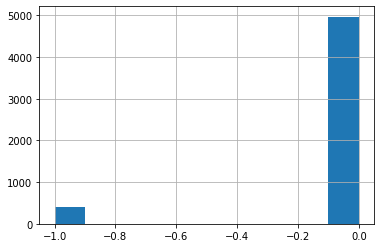

0.05 7


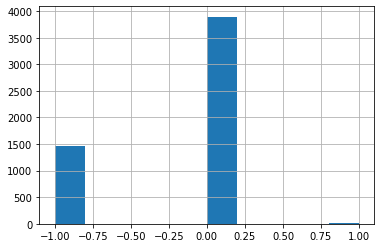

0.063 31


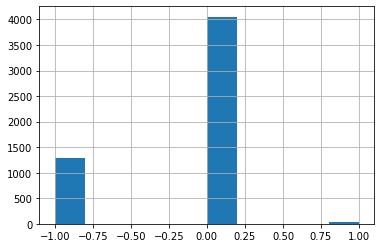

0.05 11


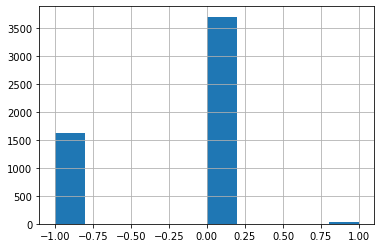

0.038 11


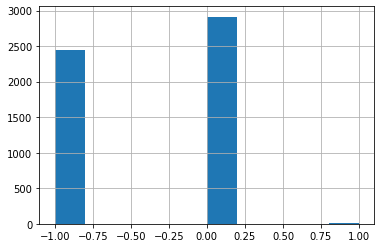

0.05 41


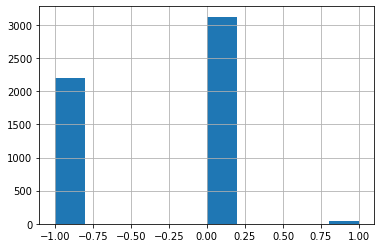

0.05 43


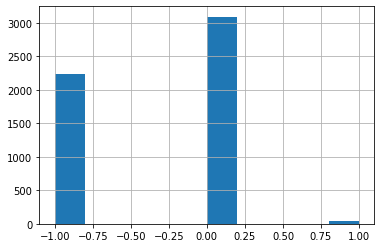

0.038 19


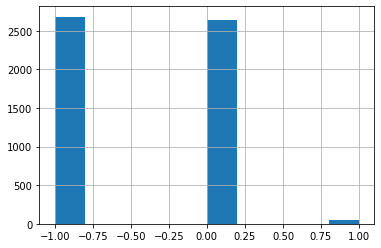

0.038 21


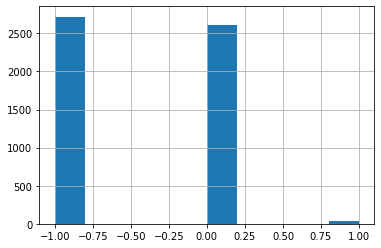

0.038 23


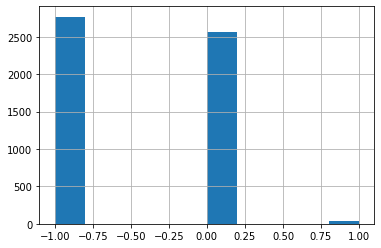

0.025 17


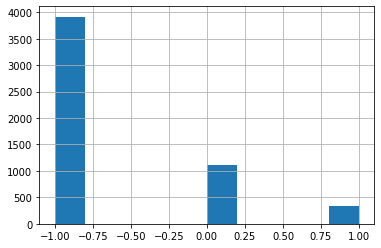

0.025 23


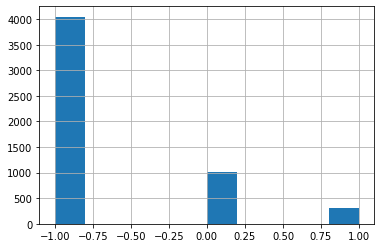

0.025 25


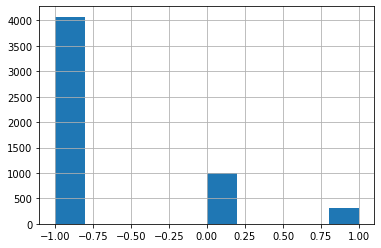

0.025 27


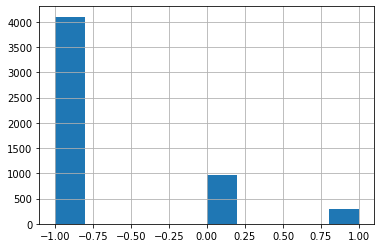

0.025 29


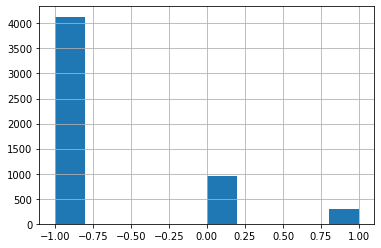

0.025 31


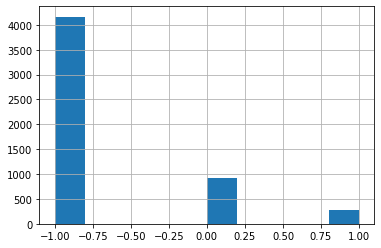

In [ ]:
for conf in np.array(db_config[['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    #plt.yscale('log')
    plt.grid()
    plt.show()

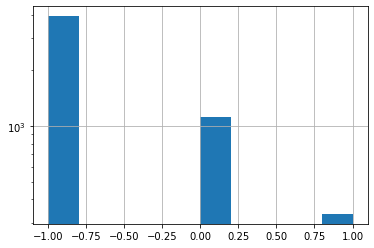

In [ ]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.025, 
                        min_samples=17, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
5587,2932.136377,1.0,0.0,0.0,0.0,1866.470014,0.0,0.000000,0.0,0.583333,12.0,0.0,3500.0,809.813492,849.210431,0.000000,12.0,-1
8560,382.378002,1.0,0.0,0.0,0.0,1097.698179,0.0,0.000000,0.0,0.250000,5.0,0.0,1500.0,679.788131,185.106686,0.100000,12.0,0
5469,1097.285930,1.0,0.0,0.0,0.0,37.643261,0.0,0.000000,0.0,0.166667,2.0,0.0,1200.0,236.375748,259.212980,0.000000,12.0,0
6053,463.071288,1.0,0.0,0.0,0.0,1381.989484,0.0,0.000000,0.0,0.250000,7.0,0.0,1000.0,5445.356870,4496.934117,0.400000,12.0,-1
3611,93.672733,1.0,674.3,69.5,604.8,0.000000,1.0,0.166667,1.0,0.000000,0.0,26.0,5400.0,812.396962,194.901529,0.083333,12.0,1


In [ ]:
# Relabel Clusters starting from 0
X_train["cluster"] = X_train["cluster"] + 1

# Train Model on Cluster Label

In [ ]:
X_train.iloc[:,:-1]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5587,2932.136377,1.0,0.00,0.00,0.00,1866.470014,0.000000,0.000000,0.000000,0.583333,12.0,0.0,3500.0,809.813492,849.210431,0.000000,12.0
8560,382.378002,1.0,0.00,0.00,0.00,1097.698179,0.000000,0.000000,0.000000,0.250000,5.0,0.0,1500.0,679.788131,185.106686,0.100000,12.0
5469,1097.285930,1.0,0.00,0.00,0.00,37.643261,0.000000,0.000000,0.000000,0.166667,2.0,0.0,1200.0,236.375748,259.212980,0.000000,12.0
6053,463.071288,1.0,0.00,0.00,0.00,1381.989484,0.000000,0.000000,0.000000,0.250000,7.0,0.0,1000.0,5445.356870,4496.934117,0.400000,12.0
3611,93.672733,1.0,674.30,69.50,604.80,0.000000,1.000000,0.166667,1.000000,0.000000,0.0,26.0,5400.0,812.396962,194.901529,0.083333,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,1150.042040,1.0,1283.45,318.67,964.78,47.044876,1.000000,0.250000,0.916667,0.083333,1.0,27.0,3500.0,2430.864396,419.675603,0.000000,12.0
7763,845.815387,1.0,37.50,0.00,37.50,0.000000,0.083333,0.000000,0.083333,0.000000,0.0,1.0,1000.0,0.000000,311.800297,0.000000,12.0
5218,528.651164,1.0,4978.23,2870.42,2107.81,0.000000,0.916667,0.833333,0.500000,0.000000,0.0,60.0,6000.0,4465.155013,165.366492,0.916667,12.0
1346,661.135323,1.0,568.81,141.69,427.12,618.553380,0.750000,0.083333,0.666667,0.166667,2.0,10.0,1700.0,239.759567,208.292600,0.000000,12.0


In [ ]:
y = X_train['cluster']

In [ ]:
# create a train/test split
X_train_train, X_train_test, y_train, y_test = train_test_split(
    X_train.iloc[:,:-1], 
    y, 
    test_size=0.3, 
    random_state=123)

# Training Sklearn Random Forest b/c of Multiclass Shap Compatibility!

In [ ]:
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [ ]:
clf.fit(X_train_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [ ]:
# evaluate accuracy on training set
clf.score(X_train_train, y_train)

0.99122106943336

In [ ]:
# evaluate accuracy on test set
clf.score(X_train_test, y_test)

0.9515828677839852

In [ ]:
pred = clf.predict(X_train_train)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Tuning Random Forest

In [ ]:
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [ ]:
model.fit(X_train_train, y_train)


81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200)})

In [ ]:
# evaluate accuracy on training set
model.score(X_train_train, y_train)

1.0

In [ ]:
# evaluate accuracy on test set
model.score(X_train_test, y_test)

0.9534450651769087

In [ ]:
# predict
model.predict(X_train_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
model.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [ ]:
# Save the trained classifier
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

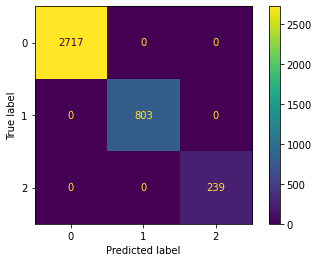

In [ ]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_train), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()

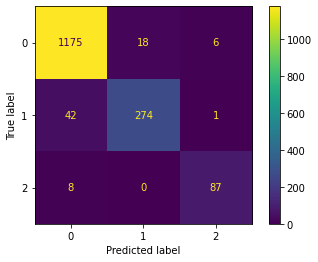

In [ ]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_train_test), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()